In [60]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [61]:
import sys
sys.path.append("../")
import numpy as np
from itertools import product
from matplotlib import pyplot as plt
import seaborn as sns
from simulation import *

### Bivariate Normal Data Generation

In [181]:
from simulation import get_sampler, cls_to_dset, get_train_test_samples
MU = {
    0: [4, 3],
    1: [3, 1],
    2: [2, 4],
    3: [1, 5]
}
std = 0.2
COV = {
    0: np.eye(2)*std**2,
    1: np.eye(2)*std**2,
    2: np.eye(2)*std**2,
    3: np.eye(2)*std**2
}
K = 4
SAMPLERS = get_sampler(MU, COV, K)
# Get SAMPLES
n = 1000
X_TRAIN, Y_TRAIN, X_TEST, Y_TEST = get_train_test_samples(SAMPLERS=SAMPLERS, n=n)
# Dataset
IND_CLS = [0, 1, 2]
OOD_CLS = [3]
IND_DATA, IND_X, IND_Y = cls_to_dset(IND_CLS, X_TRAIN, Y_TRAIN)
OOD_DATA, OOD_X, OOD_Y = cls_to_dset(OOD_CLS, X_TRAIN, Y_TRAIN)
IND_DATA_TEST, IND_X_TEST, IND_Y_TEST = cls_to_dset(IND_CLS, X_TEST, Y_TEST)
OOD_DATA_TEST, OOD_X_TEST, OOD_Y_TEST = cls_to_dset(OOD_CLS, X_TEST, Y_TEST)

#### Plot

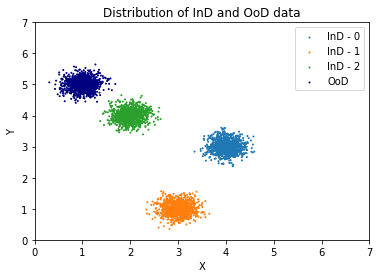

In [182]:
for idx in IND_CLS:
    plt.scatter(IND_X[:,0][IND_Y==idx], IND_X[:,1][IND_Y==idx], label =f"InD - {idx}", sizes=[1]*len(IND_X),alpha=1)
plt.scatter(OOD_X[:,0], OOD_X[:,1], c='navy', label ="OoD", sizes=[1]*len(OOD_X), alpha=1)
plt.xlim((0, 7))
plt.ylim((0, 7))
plt.legend()
plt.xlabel("X")
plt.ylabel("Y")
plt.title("Distribution of InD and OoD data")
plt.show()

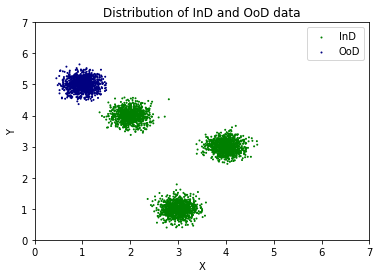

In [159]:
plt.scatter(IND_X[:,0], IND_X[:,1], c='green', label ="InD", sizes=[1]*len(IND_X),alpha=1)
plt.scatter(OOD_X[:,0], OOD_X[:,1], c='navy', label ="OoD", sizes=[1]*len(OOD_X), alpha=1)
plt.xlim((0, 7))
plt.ylim((0, 7))
plt.legend()
plt.xlabel("X")
plt.ylabel("Y")
plt.title("Distribution of InD and OoD data")
plt.show()

### Naive Classifier Training

In [183]:
from tqdm import tqdm
from simulation import classifier_training, DSIM_SINGLE, GSIM_SINGLE
# D = DSIM()
D = DSIM_SINGLE()
# Configuration
max_epoch = 256
lr = 1e-3
optimizer = torch.optim.Adam(D.parameters(), lr=lr, betas=(0.9, 0.999))
criterion = nn.CrossEntropyLoss()
# Dataset
ind_tri_loader = torch.utils.data.DataLoader(IND_DATA, shuffle=True, batch_size=256)
ind_val_loader = torch.utils.data.DataLoader(IND_DATA_TEST, shuffle=True, batch_size=256)
# Training
D = classifier_training(D, criterion, optimizer, ind_tri_loader, ind_val_loader, max_epoch, n_epoch=50)
torch.save(D.state_dict(), "simulation_log/model/D.pt")

  2%|▏         | 4/256 [00:00<00:14, 17.16it/s]

Epoch  # 1 | Tri loss: 1.476                     | Tri accuracy: 0.3327
Epoch  # 1 | Val loss: 1.4297                     | Val accuracy: 0.333


 21%|██        | 54/256 [00:02<00:09, 22.24it/s]

Epoch  # 51 | Tri loss: 0.2605                     | Tri accuracy: 1.0
Epoch  # 51 | Val loss: 0.2559                     | Val accuracy: 0.9993


 41%|████      | 105/256 [00:04<00:05, 26.02it/s]

Epoch  # 101 | Tri loss: 0.0582                     | Tri accuracy: 1.0
Epoch  # 101 | Val loss: 0.0575                     | Val accuracy: 1.0


 61%|██████    | 156/256 [00:06<00:03, 26.34it/s]

Epoch  # 151 | Tri loss: 0.0217                     | Tri accuracy: 1.0
Epoch  # 151 | Val loss: 0.0218                     | Val accuracy: 1.0


 80%|███████▉  | 204/256 [00:08<00:01, 26.51it/s]

Epoch  # 201 | Tri loss: 0.0108                     | Tri accuracy: 1.0
Epoch  # 201 | Val loss: 0.0109                     | Val accuracy: 1.0


100%|█████████▉| 255/256 [00:10<00:00, 26.07it/s]

Epoch  # 251 | Tri loss: 0.0062                     | Tri accuracy: 1.0
Epoch  # 251 | Val loss: 0.0063                     | Val accuracy: 1.0


100%|██████████| 256/256 [00:10<00:00, 23.98it/s]


#### Plot

torch.Size([10000, 3])


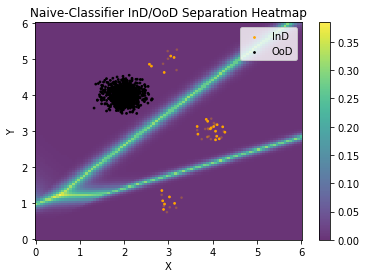

In [568]:
plot_wood = plot_heatmap(IND_X=IND_X, IND_X_TEST=IND_X_TEST, OOD_X=OOD_X, OOD_BATCH=OOD_X, 
                    D=D, method="Naive-Classifier", m=100)

### WOOD Training

In [184]:
from simulation import *
# D_WOOD = DSIM(64)
D_WOOD = DSIM_SINGLE()
# OOD data preparation
n_ood = 4
ood_bsz = 4
OOD_BATCH = torch.tensor(OOD_X[np.random.choice(n, n_ood, replace=False)], dtype=torch.float32)
torch.save(OOD_BATCH, "simulation_log/model/ood_batch.pt")
print(f"OOD Batch Shape: {OOD_BATCH.shape}")
# Configuration
max_epoch = 256
lr = 1e-3
beta = 1
optimizer = torch.optim.Adam(D_WOOD.parameters(), lr=lr, betas=(0.9, 0.999))
criterion = nn.CrossEntropyLoss()
# Dataset
ind_tri_loader = torch.utils.data.DataLoader(IND_DATA, shuffle=True, batch_size=256)
ind_val_loader = torch.utils.data.DataLoader(IND_DATA_TEST, shuffle=True, batch_size=256)
# Training
D_WOOD = wood_training(D_WOOD, OOD_BATCH, ood_bsz, beta, criterion, optimizer, ind_tri_loader, ind_val_loader, max_epoch, n_epoch=10)

OOD Batch Shape: torch.Size([4, 2])


  0%|          | 1/256 [00:00<02:28,  1.72it/s]

Epoch  # 1 | Tri loss: 1.4489                     | Tri accuracy: 0.0
tensor(0.1373, grad_fn=<WassersteinBackward>)
Epoch  # 1 | Val loss: 1.4959                     | Val accuracy: 0.0


  4%|▍         | 11/256 [00:05<02:01,  2.02it/s]

Epoch  # 11 | Tri loss: 0.7317                     | Tri accuracy: 0.3338
tensor(0.3878, grad_fn=<WassersteinBackward>)
Epoch  # 11 | Val loss: 1.1086                     | Val accuracy: 0.3329


  8%|▊         | 21/256 [00:10<02:01,  1.94it/s]

Epoch  # 21 | Tri loss: 0.6038                     | Tri accuracy: 0.6659
tensor(0.3896, grad_fn=<WassersteinBackward>)
Epoch  # 21 | Val loss: 0.9877                     | Val accuracy: 0.6673


 12%|█▏        | 31/256 [00:15<01:51,  2.01it/s]

Epoch  # 31 | Tri loss: 0.5457                     | Tri accuracy: 0.667
tensor(0.3904, grad_fn=<WassersteinBackward>)
Epoch  # 31 | Val loss: 0.9338                     | Val accuracy: 0.6655


 16%|█▌        | 41/256 [00:20<01:44,  2.06it/s]

Epoch  # 41 | Tri loss: 0.512                     | Tri accuracy: 0.6663
tensor(0.3898, grad_fn=<WassersteinBackward>)
Epoch  # 41 | Val loss: 0.9                     | Val accuracy: 0.6661


 20%|█▉        | 51/256 [00:25<01:39,  2.06it/s]

Epoch  # 51 | Tri loss: 0.4851                     | Tri accuracy: 0.6668
tensor(0.3900, grad_fn=<WassersteinBackward>)
Epoch  # 51 | Val loss: 0.8743                     | Val accuracy: 0.6643


 24%|██▍       | 61/256 [00:30<01:33,  2.09it/s]

Epoch  # 61 | Tri loss: 0.4582                     | Tri accuracy: 0.6666
tensor(0.3891, grad_fn=<WassersteinBackward>)
Epoch  # 61 | Val loss: 0.8451                     | Val accuracy: 0.665


 28%|██▊       | 71/256 [00:35<01:30,  2.04it/s]

Epoch  # 71 | Tri loss: 0.3684                     | Tri accuracy: 0.986
tensor(0.3882, grad_fn=<WassersteinBackward>)
Epoch  # 71 | Val loss: 0.7402                     | Val accuracy: 0.9989


 32%|███▏      | 81/256 [00:40<01:31,  1.91it/s]

Epoch  # 81 | Tri loss: 0.1891                     | Tri accuracy: 0.9964
tensor(0.3869, grad_fn=<WassersteinBackward>)
Epoch  # 81 | Val loss: 0.5686                     | Val accuracy: 0.9963


 36%|███▌      | 91/256 [00:45<01:18,  2.10it/s]

Epoch  # 91 | Tri loss: 0.0875                     | Tri accuracy: 0.9966
tensor(0.3864, grad_fn=<WassersteinBackward>)
Epoch  # 91 | Val loss: 0.4693                     | Val accuracy: 0.9964


 39%|███▉      | 101/256 [00:50<01:18,  1.97it/s]

Epoch  # 101 | Tri loss: 0.0216                     | Tri accuracy: 0.9979
tensor(0.3845, grad_fn=<WassersteinBackward>)
Epoch  # 101 | Val loss: 0.4023                     | Val accuracy: 0.9984


 43%|████▎     | 111/256 [00:55<01:15,  1.91it/s]

Epoch  # 111 | Tri loss: -0.0272                     | Tri accuracy: 0.999
tensor(0.3827, grad_fn=<WassersteinBackward>)
Epoch  # 111 | Val loss: 0.3543                     | Val accuracy: 0.999


 47%|████▋     | 121/256 [01:00<01:06,  2.04it/s]

Epoch  # 121 | Tri loss: -0.0657                     | Tri accuracy: 0.9997
tensor(0.3817, grad_fn=<WassersteinBackward>)
Epoch  # 121 | Val loss: 0.3149                     | Val accuracy: 0.9993


 51%|█████     | 131/256 [01:05<01:01,  2.02it/s]

Epoch  # 131 | Tri loss: -0.0958                     | Tri accuracy: 1.0
tensor(0.3808, grad_fn=<WassersteinBackward>)
Epoch  # 131 | Val loss: 0.2839                     | Val accuracy: 0.9993


 55%|█████▌    | 141/256 [01:10<01:02,  1.84it/s]

Epoch  # 141 | Tri loss: -0.1202                     | Tri accuracy: 1.0
tensor(0.3793, grad_fn=<WassersteinBackward>)
Epoch  # 141 | Val loss: 0.2583                     | Val accuracy: 0.9993


 59%|█████▉    | 151/256 [01:17<01:11,  1.47it/s]

Epoch  # 151 | Tri loss: -0.1408                     | Tri accuracy: 1.0
tensor(0.3779, grad_fn=<WassersteinBackward>)
Epoch  # 151 | Val loss: 0.2366                     | Val accuracy: 0.9997


 63%|██████▎   | 161/256 [01:23<00:59,  1.61it/s]

Epoch  # 161 | Tri loss: -0.1583                     | Tri accuracy: 1.0
tensor(0.3773, grad_fn=<WassersteinBackward>)
Epoch  # 161 | Val loss: 0.219                     | Val accuracy: 0.9997


 67%|██████▋   | 171/256 [01:29<00:46,  1.82it/s]

Epoch  # 171 | Tri loss: -0.1732                     | Tri accuracy: 1.0
tensor(0.3765, grad_fn=<WassersteinBackward>)
Epoch  # 171 | Val loss: 0.2047                     | Val accuracy: 1.0


 71%|███████   | 181/256 [01:34<00:34,  2.20it/s]

Epoch  # 181 | Tri loss: -0.1851                     | Tri accuracy: 1.0
tensor(0.3763, grad_fn=<WassersteinBackward>)
Epoch  # 181 | Val loss: 0.1901                     | Val accuracy: 1.0


 75%|███████▍  | 191/256 [01:39<00:34,  1.88it/s]

Epoch  # 191 | Tri loss: -0.1967                     | Tri accuracy: 1.0
tensor(0.3753, grad_fn=<WassersteinBackward>)
Epoch  # 191 | Val loss: 0.1784                     | Val accuracy: 1.0


 79%|███████▊  | 201/256 [01:44<00:29,  1.86it/s]

Epoch  # 201 | Tri loss: -0.2057                     | Tri accuracy: 1.0
tensor(0.3749, grad_fn=<WassersteinBackward>)
Epoch  # 201 | Val loss: 0.1688                     | Val accuracy: 1.0


 82%|████████▏ | 211/256 [01:50<00:24,  1.81it/s]

Epoch  # 211 | Tri loss: -0.2147                     | Tri accuracy: 1.0
tensor(0.3745, grad_fn=<WassersteinBackward>)
Epoch  # 211 | Val loss: 0.1596                     | Val accuracy: 1.0


 86%|████████▋ | 221/256 [01:55<00:18,  1.88it/s]

Epoch  # 221 | Tri loss: -0.2221                     | Tri accuracy: 1.0
tensor(0.3734, grad_fn=<WassersteinBackward>)
Epoch  # 221 | Val loss: 0.1518                     | Val accuracy: 1.0


 90%|█████████ | 231/256 [02:00<00:14,  1.77it/s]

Epoch  # 231 | Tri loss: -0.2285                     | Tri accuracy: 1.0
tensor(0.3733, grad_fn=<WassersteinBackward>)
Epoch  # 231 | Val loss: 0.1441                     | Val accuracy: 1.0


 94%|█████████▍| 241/256 [02:06<00:08,  1.84it/s]

Epoch  # 241 | Tri loss: -0.2345                     | Tri accuracy: 1.0
tensor(0.3728, grad_fn=<WassersteinBackward>)
Epoch  # 241 | Val loss: 0.1379                     | Val accuracy: 1.0


 98%|█████████▊| 251/256 [02:11<00:02,  1.81it/s]

Epoch  # 251 | Tri loss: -0.2402                     | Tri accuracy: 1.0
tensor(0.3730, grad_fn=<WassersteinBackward>)
Epoch  # 251 | Val loss: 0.1321                     | Val accuracy: 1.0


100%|██████████| 256/256 [02:14<00:00,  1.90it/s]


In [185]:
from simulation import calculate_accuracy
# calculate_accuracy(D=D, ind=IND_X, ood=OOD_X, tnr=0.95)
calculate_accuracy(D=D_WOOD, ind=IND_X, ood=OOD_X, tnr=0.95)
# calculate_accuracy(D=D, ind=IND_X, ood=OOD_X, tnr=0.99)
calculate_accuracy(D=D_WOOD, ind=IND_X, ood=OOD_X, tnr=0.99)
# calculate_accuracy(D=D, ind=IND_X, ood=OOD_X, tnr=0.999)
calculate_accuracy(D=D_WOOD, ind=IND_X, ood=OOD_X, tnr=0.999)

0.95: 1.0
0.99: 1.0
0.999: 0.9980000257492065


0.18230908933281906

### OOD GAN Training

In [188]:
from simulation import *
from wasserstein import *
# D_GAN = DSIM(64)
# G_GAN = GSIM(64)
D_GAN = DSIM_SINGLE()
G_GAN = GSIM_SINGLE()
# OOD data preparation
n_ood = 8
ood_bsz = 8
bsz_tri = 64
OOD_BATCH = torch.tensor(OOD_X[np.random.choice(n, n_ood, replace=False)], dtype=torch.float32)
print(f"OOD Batch Shape: {OOD_BATCH.shape}")
# Configuration
max_epoch = 256
lr = 1e-4
w_ce, w_wass, w_dist = 1, 0.1, 0.1
n_dim = 1
D_solver = torch.optim.Adam(D_GAN.parameters(), lr=lr, betas=(0.5, 0.999))
G_solver = torch.optim.Adam(G_GAN.parameters(), lr=lr, betas=(0.5, 0.999))
criterion = nn.CrossEntropyLoss()
# Dataset
ind_tri_loader = torch.utils.data.DataLoader(IND_DATA, shuffle=True, batch_size=256)
ind_val_loader = torch.utils.data.DataLoader(IND_DATA_TEST, shuffle=True, batch_size=256)
# Training
oodgan_training(D_GAN, G_GAN, D_solver, G_solver, OOD_BATCH, ood_bsz, bsz_tri, w_ce, w_wass, w_dist,\
                    ind_tri_loader, ind_val_loader, max_epoch, n_epoch=5, n_step_log=10)

OOD Batch Shape: torch.Size([8, 2])


  0%|          | 0/256 [00:00<?, ?it/s]

Step: 0    | D:  2.7339 | CE:  2.7426 | W_OoD:  0.1173 | W_z:  0.2989 | G: -0.0030 | W_z:  0.2978 | dist: 3.6838
Step: 10   | D:  2.7931 | CE:  2.8022 | W_OoD:  0.1212 | W_z:  0.2991 | G: -0.0030 | W_z:  0.2994 | dist: 3.6995


  0%|          | 1/256 [00:14<1:00:15, 14.18s/it]

Epoch  # 1 | Val accuracy: 0.3348
Step: 8    | D:  2.4431 | CE:  2.4527 | W_OoD:  0.1252 | W_z:  0.2973 | G: -0.0030 | W_z:  0.2973 | dist: 3.6936


  1%|          | 2/256 [00:27<58:44, 13.88s/it]  

Step: 6    | D:  2.7377 | CE:  2.7476 | W_OoD:  0.1293 | W_z:  0.2974 | G: -0.0030 | W_z:  0.2966 | dist: 3.7011


  1%|          | 3/256 [00:43<1:01:06, 14.49s/it]

Step: 4    | D:  3.0308 | CE:  3.0412 | W_OoD:  0.1335 | W_z:  0.2959 | G: -0.0029 | W_z:  0.2946 | dist: 3.6971


  2%|▏         | 4/256 [00:57<1:00:06, 14.31s/it]

Step: 2    | D:  2.7872 | CE:  2.7980 | W_OoD:  0.1377 | W_z:  0.2939 | G: -0.0029 | W_z:  0.2948 | dist: 3.6988


  2%|▏         | 5/256 [01:11<59:14, 14.16s/it]  

Step: 0    | D:  2.7899 | CE:  2.8011 | W_OoD:  0.1420 | W_z:  0.2945 | G: -0.0029 | W_z:  0.2918 | dist: 3.6932
Step: 10   | D:  2.5704 | CE:  2.5822 | W_OoD:  0.1463 | W_z:  0.2927 | G: -0.0029 | W_z:  0.2923 | dist: 3.6779


  2%|▏         | 6/256 [01:24<58:27, 14.03s/it]

Epoch  # 6 | Val accuracy: 0.3333
Step: 8    | D:  2.5974 | CE:  2.6096 | W_OoD:  0.1507 | W_z:  0.2908 | G: -0.0029 | W_z:  0.2925 | dist: 3.6961


  3%|▎         | 7/256 [01:38<57:49, 13.93s/it]

Step: 6    | D:  2.2831 | CE:  2.2957 | W_OoD:  0.1553 | W_z:  0.2920 | G: -0.0029 | W_z:  0.2913 | dist: 3.6920


  3%|▎         | 8/256 [01:52<57:20, 13.87s/it]

Step: 4    | D:  2.7053 | CE:  2.7184 | W_OoD:  0.1598 | W_z:  0.2904 | G: -0.0029 | W_z:  0.2897 | dist: 3.6972


  4%|▎         | 9/256 [02:06<56:57, 13.83s/it]

Step: 2    | D:  2.6251 | CE:  2.6387 | W_OoD:  0.1643 | W_z:  0.2896 | G: -0.0029 | W_z:  0.2910 | dist: 3.6857


  4%|▍         | 10/256 [02:19<56:45, 13.85s/it]

Step: 0    | D:  2.6709 | CE:  2.6849 | W_OoD:  0.1688 | W_z:  0.2893 | G: -0.0029 | W_z:  0.2881 | dist: 3.6849
Step: 10   | D:  2.4800 | CE:  2.4945 | W_OoD:  0.1734 | W_z:  0.2883 | G: -0.0029 | W_z:  0.2884 | dist: 3.6731


  4%|▍         | 11/256 [02:33<56:23, 13.81s/it]

Epoch  # 11 | Val accuracy: 0.3329
Step: 8    | D:  2.4376 | CE:  2.4526 | W_OoD:  0.1781 | W_z:  0.2877 | G: -0.0029 | W_z:  0.2870 | dist: 3.6782


  5%|▍         | 12/256 [02:47<56:02, 13.78s/it]

Step: 6    | D:  2.4250 | CE:  2.4405 | W_OoD:  0.1829 | W_z:  0.2873 | G: -0.0029 | W_z:  0.2861 | dist: 3.6689


  5%|▌         | 13/256 [03:01<56:17, 13.90s/it]

Step: 4    | D:  2.5243 | CE:  2.5402 | W_OoD:  0.1877 | W_z:  0.2856 | G: -0.0029 | W_z:  0.2863 | dist: 3.6646


  5%|▌         | 14/256 [03:15<55:50, 13.84s/it]

Step: 2    | D:  2.7312 | CE:  2.7476 | W_OoD:  0.1925 | W_z:  0.2847 | G: -0.0028 | W_z:  0.2839 | dist: 3.6672


  6%|▌         | 15/256 [03:28<55:09, 13.73s/it]

Step: 0    | D:  2.6804 | CE:  2.6973 | W_OoD:  0.1974 | W_z:  0.2843 | G: -0.0028 | W_z:  0.2841 | dist: 3.6689
Step: 10   | D:  2.3904 | CE:  2.4078 | W_OoD:  0.2024 | W_z:  0.2824 | G: -0.0028 | W_z:  0.2841 | dist: 3.6668


  6%|▋         | 16/256 [03:42<54:46, 13.70s/it]

Epoch  # 16 | Val accuracy: 0.3333
Step: 8    | D:  2.2549 | CE:  2.2728 | W_OoD:  0.2074 | W_z:  0.2841 | G: -0.0028 | W_z:  0.2825 | dist: 3.6613


  7%|▋         | 17/256 [03:56<54:45, 13.75s/it]

Step: 6    | D:  2.4769 | CE:  2.4953 | W_OoD:  0.2125 | W_z:  0.2830 | G: -0.0028 | W_z:  0.2830 | dist: 3.6601


  7%|▋         | 18/256 [04:09<54:15, 13.68s/it]

Step: 4    | D:  2.5810 | CE:  2.5999 | W_OoD:  0.2177 | W_z:  0.2830 | G: -0.0028 | W_z:  0.2838 | dist: 3.6294


  7%|▋         | 19/256 [04:23<53:59, 13.67s/it]

Step: 2    | D:  2.4021 | CE:  2.4216 | W_OoD:  0.2229 | W_z:  0.2832 | G: -0.0028 | W_z:  0.2822 | dist: 3.6582


  8%|▊         | 20/256 [04:36<53:40, 13.65s/it]

Step: 0    | D:  2.3334 | CE:  2.3534 | W_OoD:  0.2282 | W_z:  0.2816 | G: -0.0028 | W_z:  0.2814 | dist: 3.6597
Step: 10   | D:  2.4485 | CE:  2.4690 | W_OoD:  0.2336 | W_z:  0.2804 | G: -0.0028 | W_z:  0.2827 | dist: 3.6313


  8%|▊         | 21/256 [04:50<53:31, 13.67s/it]

Epoch  # 21 | Val accuracy: 0.333
Step: 8    | D:  2.1359 | CE:  2.1569 | W_OoD:  0.2390 | W_z:  0.2818 | G: -0.0028 | W_z:  0.2808 | dist: 3.6369


  9%|▊         | 22/256 [05:04<53:06, 13.62s/it]

Step: 6    | D:  2.3465 | CE:  2.3681 | W_OoD:  0.2444 | W_z:  0.2810 | G: -0.0028 | W_z:  0.2792 | dist: 3.6455


  9%|▉         | 23/256 [05:17<53:03, 13.67s/it]

Step: 4    | D:  2.3652 | CE:  2.3873 | W_OoD:  0.2499 | W_z:  0.2801 | G: -0.0028 | W_z:  0.2820 | dist: 3.5988


  9%|▉         | 24/256 [05:31<52:50, 13.67s/it]

Step: 2    | D:  2.4540 | CE:  2.4767 | W_OoD:  0.2552 | W_z:  0.2789 | G: -0.0028 | W_z:  0.2804 | dist: 3.6128


 10%|▉         | 25/256 [05:45<52:28, 13.63s/it]

Step: 0    | D:  2.5048 | CE:  2.5281 | W_OoD:  0.2606 | W_z:  0.2787 | G: -0.0028 | W_z:  0.2809 | dist: 3.5964
Step: 10   | D:  2.5171 | CE:  2.5409 | W_OoD:  0.2660 | W_z:  0.2815 | G: -0.0028 | W_z:  0.2819 | dist: 3.5820


 10%|█         | 26/256 [05:58<52:10, 13.61s/it]

Epoch  # 26 | Val accuracy: 0.3344
Step: 8    | D:  2.1894 | CE:  2.2137 | W_OoD:  0.2714 | W_z:  0.2802 | G: -0.0028 | W_z:  0.2815 | dist: 3.5829


 11%|█         | 27/256 [06:12<52:03, 13.64s/it]

Step: 6    | D:  2.2395 | CE:  2.2644 | W_OoD:  0.2769 | W_z:  0.2808 | G: -0.0028 | W_z:  0.2806 | dist: 3.5996


 11%|█         | 28/256 [06:25<51:41, 13.60s/it]

Step: 4    | D:  2.0988 | CE:  2.1242 | W_OoD:  0.2824 | W_z:  0.2802 | G: -0.0028 | W_z:  0.2799 | dist: 3.5880


 11%|█▏        | 29/256 [06:39<51:16, 13.55s/it]

Step: 2    | D:  2.0405 | CE:  2.0665 | W_OoD:  0.2879 | W_z:  0.2797 | G: -0.0028 | W_z:  0.2816 | dist: 3.5795


 12%|█▏        | 30/256 [06:52<51:05, 13.56s/it]

Step: 0    | D:  2.2160 | CE:  2.2425 | W_OoD:  0.2934 | W_z:  0.2803 | G: -0.0028 | W_z:  0.2798 | dist: 3.5862
Step: 10   | D:  2.0525 | CE:  2.0795 | W_OoD:  0.2983 | W_z:  0.2790 | G: -0.0028 | W_z:  0.2788 | dist: 3.6001


 12%|█▏        | 31/256 [07:06<50:45, 13.54s/it]

Epoch  # 31 | Val accuracy: 0.3324
Step: 8    | D:  2.2564 | CE:  2.2838 | W_OoD:  0.3024 | W_z:  0.2815 | G: -0.0028 | W_z:  0.2793 | dist: 3.5783


 12%|█▎        | 32/256 [07:19<50:30, 13.53s/it]

Step: 6    | D:  2.1076 | CE:  2.1354 | W_OoD:  0.3053 | W_z:  0.2787 | G: -0.0028 | W_z:  0.2818 | dist: 3.5563


 13%|█▎        | 33/256 [07:33<50:19, 13.54s/it]

Step: 4    | D:  2.2250 | CE:  2.2529 | W_OoD:  0.3070 | W_z:  0.2819 | G: -0.0028 | W_z:  0.2781 | dist: 3.5779


 13%|█▎        | 34/256 [07:46<49:59, 13.51s/it]

Step: 2    | D:  2.1584 | CE:  2.1865 | W_OoD:  0.3085 | W_z:  0.2809 | G: -0.0028 | W_z:  0.2783 | dist: 3.5758


 14%|█▎        | 35/256 [08:00<49:53, 13.55s/it]

Step: 0    | D:  2.1419 | CE:  2.1701 | W_OoD:  0.3100 | W_z:  0.2789 | G: -0.0028 | W_z:  0.2814 | dist: 3.5475
Step: 10   | D:  1.8611 | CE:  1.8895 | W_OoD:  0.3117 | W_z:  0.2772 | G: -0.0028 | W_z:  0.2806 | dist: 3.5474


 14%|█▍        | 36/256 [08:14<50:00, 13.64s/it]

Epoch  # 36 | Val accuracy: 0.3343
Step: 8    | D:  2.0108 | CE:  2.0394 | W_OoD:  0.3137 | W_z:  0.2846 | G: -0.0028 | W_z:  0.2788 | dist: 3.5523


 14%|█▍        | 37/256 [08:28<49:46, 13.64s/it]

Step: 6    | D:  1.9778 | CE:  2.0065 | W_OoD:  0.3149 | W_z:  0.2796 | G: -0.0028 | W_z:  0.2795 | dist: 3.5417


 15%|█▍        | 38/256 [08:41<49:26, 13.61s/it]

Step: 4    | D:  1.9322 | CE:  1.9610 | W_OoD:  0.3161 | W_z:  0.2795 | G: -0.0028 | W_z:  0.2789 | dist: 3.5367


 15%|█▌        | 39/256 [08:55<49:12, 13.60s/it]

Step: 2    | D:  2.1372 | CE:  2.1662 | W_OoD:  0.3175 | W_z:  0.2792 | G: -0.0028 | W_z:  0.2774 | dist: 3.5534


 16%|█▌        | 40/256 [09:08<48:52, 13.58s/it]

Step: 0    | D:  2.0826 | CE:  2.1117 | W_OoD:  0.3187 | W_z:  0.2775 | G: -0.0028 | W_z:  0.2813 | dist: 3.5154
Step: 10   | D:  2.0947 | CE:  2.1239 | W_OoD:  0.3200 | W_z:  0.2826 | G: -0.0028 | W_z:  0.2799 | dist: 3.5200


 16%|█▌        | 41/256 [09:22<48:35, 13.56s/it]

Epoch  # 41 | Val accuracy: 0.3335
Step: 8    | D:  2.0651 | CE:  2.0945 | W_OoD:  0.3214 | W_z:  0.2795 | G: -0.0028 | W_z:  0.2834 | dist: 3.4972


 16%|█▋        | 42/256 [09:35<48:27, 13.59s/it]

Step: 6    | D:  2.1114 | CE:  2.1408 | W_OoD:  0.3224 | W_z:  0.2828 | G: -0.0028 | W_z:  0.2824 | dist: 3.5003


 17%|█▋        | 43/256 [09:49<48:04, 13.54s/it]

Step: 4    | D:  2.1298 | CE:  2.1594 | W_OoD:  0.3234 | W_z:  0.2811 | G: -0.0028 | W_z:  0.2797 | dist: 3.5076


 17%|█▋        | 44/256 [10:02<47:51, 13.54s/it]

Step: 2    | D:  2.0071 | CE:  2.0366 | W_OoD:  0.3245 | W_z:  0.2858 | G: -0.0028 | W_z:  0.2812 | dist: 3.4986


 18%|█▊        | 45/256 [10:16<47:49, 13.60s/it]

Step: 0    | D:  2.0519 | CE:  2.0816 | W_OoD:  0.3256 | W_z:  0.2809 | G: -0.0028 | W_z:  0.2824 | dist: 3.4859
Step: 10   | D:  1.8207 | CE:  1.8505 | W_OoD:  0.3269 | W_z:  0.2801 | G: -0.0028 | W_z:  0.2820 | dist: 3.4843


 18%|█▊        | 46/256 [10:30<47:32, 13.59s/it]

Epoch  # 46 | Val accuracy: 0.3339
Step: 8    | D:  1.7960 | CE:  1.8259 | W_OoD:  0.3282 | W_z:  0.2839 | G: -0.0028 | W_z:  0.2839 | dist: 3.4654


 18%|█▊        | 47/256 [10:43<47:09, 13.54s/it]

Step: 6    | D:  1.8065 | CE:  1.8367 | W_OoD:  0.3295 | W_z:  0.2822 | G: -0.0028 | W_z:  0.2816 | dist: 3.4719


 19%|█▉        | 48/256 [10:57<46:58, 13.55s/it]

Step: 4    | D:  1.9383 | CE:  1.9685 | W_OoD:  0.3308 | W_z:  0.2837 | G: -0.0028 | W_z:  0.2813 | dist: 3.4731


 19%|█▉        | 49/256 [11:10<46:46, 13.56s/it]

Step: 2    | D:  2.0734 | CE:  2.1037 | W_OoD:  0.3321 | W_z:  0.2846 | G: -0.0028 | W_z:  0.2825 | dist: 3.4640


 20%|█▉        | 50/256 [11:24<46:35, 13.57s/it]

Step: 0    | D:  1.8467 | CE:  1.8772 | W_OoD:  0.3334 | W_z:  0.2820 | G: -0.0029 | W_z:  0.2858 | dist: 3.4408
Step: 10   | D:  2.0927 | CE:  2.1234 | W_OoD:  0.3347 | W_z:  0.2844 | G: -0.0028 | W_z:  0.2841 | dist: 3.4458


 20%|█▉        | 51/256 [11:37<46:20, 13.56s/it]

Epoch  # 51 | Val accuracy: 0.3352
Step: 8    | D:  1.8145 | CE:  1.8453 | W_OoD:  0.3360 | W_z:  0.2821 | G: -0.0028 | W_z:  0.2823 | dist: 3.4554


 20%|██        | 52/256 [11:51<46:03, 13.55s/it]

Step: 6    | D:  1.9981 | CE:  2.0290 | W_OoD:  0.3372 | W_z:  0.2811 | G: -0.0028 | W_z:  0.2818 | dist: 3.4554


 21%|██        | 53/256 [12:05<46:22, 13.71s/it]

Step: 4    | D:  1.7590 | CE:  1.7900 | W_OoD:  0.3385 | W_z:  0.2847 | G: -0.0028 | W_z:  0.2815 | dist: 3.4451


 21%|██        | 54/256 [12:18<45:56, 13.64s/it]

Step: 2    | D:  1.8344 | CE:  1.8656 | W_OoD:  0.3401 | W_z:  0.2851 | G: -0.0028 | W_z:  0.2833 | dist: 3.4362


 21%|██▏       | 55/256 [12:32<45:32, 13.59s/it]

Step: 0    | D:  1.9272 | CE:  1.9586 | W_OoD:  0.3418 | W_z:  0.2810 | G: -0.0028 | W_z:  0.2807 | dist: 3.4467
Step: 10   | D:  1.8876 | CE:  1.9191 | W_OoD:  0.3436 | W_z:  0.2834 | G: -0.0029 | W_z:  0.2860 | dist: 3.4071


 22%|██▏       | 56/256 [12:46<45:23, 13.62s/it]

Epoch  # 56 | Val accuracy: 0.3329
Step: 8    | D:  1.7521 | CE:  1.7838 | W_OoD:  0.3454 | W_z:  0.2832 | G: -0.0028 | W_z:  0.2839 | dist: 3.4124


 22%|██▏       | 57/256 [13:00<45:44, 13.79s/it]

Step: 6    | D:  1.7184 | CE:  1.7503 | W_OoD:  0.3471 | W_z:  0.2836 | G: -0.0028 | W_z:  0.2819 | dist: 3.4198


 23%|██▎       | 58/256 [13:13<45:03, 13.65s/it]

Step: 4    | D:  1.7176 | CE:  1.7497 | W_OoD:  0.3489 | W_z:  0.2849 | G: -0.0028 | W_z:  0.2834 | dist: 3.4126


 23%|██▎       | 59/256 [13:29<46:50, 14.27s/it]

Step: 2    | D:  1.9824 | CE:  2.0146 | W_OoD:  0.3507 | W_z:  0.2822 | G: -0.0028 | W_z:  0.2842 | dist: 3.4054


 23%|██▎       | 60/256 [13:43<46:52, 14.35s/it]

Step: 0    | D:  2.0258 | CE:  2.0582 | W_OoD:  0.3525 | W_z:  0.2831 | G: -0.0029 | W_z:  0.2851 | dist: 3.3988
Step: 10   | D:  1.7204 | CE:  1.7530 | W_OoD:  0.3542 | W_z:  0.2846 | G: -0.0028 | W_z:  0.2841 | dist: 3.3999


 24%|██▍       | 61/256 [13:59<48:05, 14.80s/it]

Epoch  # 61 | Val accuracy: 0.3329
Step: 8    | D:  1.8027 | CE:  1.8353 | W_OoD:  0.3555 | W_z:  0.2890 | G: -0.0029 | W_z:  0.2878 | dist: 3.3731


 24%|██▍       | 62/256 [14:14<47:38, 14.74s/it]

Step: 6    | D:  1.6009 | CE:  1.6337 | W_OoD:  0.3567 | W_z:  0.2877 | G: -0.0029 | W_z:  0.2861 | dist: 3.3844


 25%|██▍       | 63/256 [14:28<47:05, 14.64s/it]

Step: 4    | D:  1.8560 | CE:  1.8890 | W_OoD:  0.3580 | W_z:  0.2864 | G: -0.0028 | W_z:  0.2843 | dist: 3.3889


 25%|██▌       | 64/256 [14:42<46:15, 14.46s/it]

Step: 2    | D:  1.5419 | CE:  1.5750 | W_OoD:  0.3593 | W_z:  0.2891 | G: -0.0029 | W_z:  0.2858 | dist: 3.3757


 25%|██▌       | 65/256 [14:57<46:05, 14.48s/it]

Step: 0    | D:  1.7663 | CE:  1.7995 | W_OoD:  0.3606 | W_z:  0.2861 | G: -0.0029 | W_z:  0.2853 | dist: 3.3690
Step: 10   | D:  1.6128 | CE:  1.6461 | W_OoD:  0.3619 | W_z:  0.2875 | G: -0.0028 | W_z:  0.2838 | dist: 3.3815


 26%|██▌       | 66/256 [15:11<46:04, 14.55s/it]

Epoch  # 66 | Val accuracy: 0.3338
Step: 8    | D:  1.7959 | CE:  1.8293 | W_OoD:  0.3633 | W_z:  0.2881 | G: -0.0029 | W_z:  0.2872 | dist: 3.3591


 26%|██▌       | 66/256 [15:24<44:22, 14.01s/it]


KeyboardInterrupt: 

### Plot

#### Plot Naive Classifier

In [63]:
m, n_ind, n_ood = 300, 25, 25
xi = np.linspace(0, 6, m, endpoint=True)
yi = np.linspace(0, 6, m, endpoint=True)
xy_pos = np.array(list(product(xi, yi)))
zi = torch.softmax(D(torch.tensor(xy_pos, dtype=torch.float32)), dim=-1)
print(zi.shape)
si = ood_wass_loss(zi)

torch.Size([90000, 3])


In [64]:
threshold =calculate_accuracy(D=D, ind=IND_X, ood=OOD_X, tnr=0.99)
mask = si > threshold

0.99: 0.003000000026077032


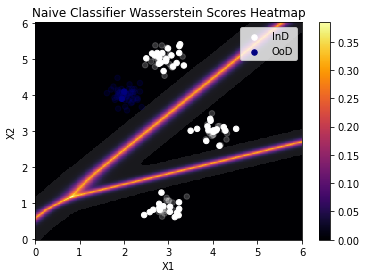

In [65]:
plt.pcolormesh(xi, yi, si.reshape((m, m)).T, shading='auto',cmap='inferno', alpha=1)
plt.colorbar()
plt.pcolormesh(xi, yi, mask.reshape((m, m)).T, shading='auto',cmap='gray', alpha=0.1)
# InD and OoD
n_ind, n_ood = 50, 50, 
ind_idx = np.random.choice(len(IND_X), n_ind, replace=False)
ood_idx = np.random.choice(len(OOD_X), n_ood, replace=False)
plt.scatter(IND_X[:,0][ind_idx], IND_X[:,1][ind_idx], c='white', label ="InD", sizes=[30]*len(IND_X), alpha=1)
plt.scatter(OOD_BATCH[:,0], OOD_BATCH[:,1], c='navy', label="OoD", sizes=[30]*len(OOD_X), alpha=1)
plt.scatter(IND_X_TEST[:,0][ind_idx], IND_X_TEST[:,1][ind_idx], c='white', sizes=[30]*len(IND_X), alpha=0.2)
plt.scatter(OOD_X[:,0][ood_idx], OOD_X[:,1][ood_idx], c='navy', sizes=[30]*len(OOD_X), alpha=0.2)
plt.title(f"Naive Classifier Wasserstein Scores Heatmap")
plt.xlabel("X1")
plt.ylabel("X2")
plt.legend()
plt.savefig(f"simulation_log/plot/example_naive.jpg", dpi=1000)

#### Plot WOOD

In [177]:
m, n_ind, n_ood = 100, 25, 25
xi = np.linspace(0, 6, m, endpoint=True)
yi = np.linspace(0, 6, m, endpoint=True)
xy_pos = np.array(list(product(xi, yi)))
zi = torch.softmax(D_WOOD(torch.tensor(xy_pos, dtype=torch.float32)), dim=-1)
print(zi.shape)
si = ood_wass_loss(zi)

torch.Size([10000, 3])


0.99: 1.0


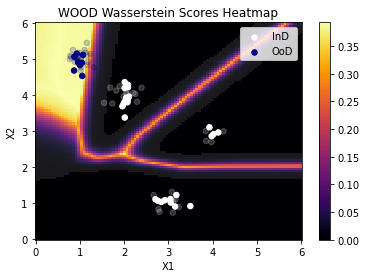

In [178]:
threshold =calculate_accuracy(D=D_WOOD, ind=IND_X, ood=OOD_X, tnr=0.99)
mask = si > threshold
plt.pcolormesh(xi, yi, si.reshape((m, m)).T, shading='auto',cmap='inferno', alpha=1)
plt.colorbar()
plt.pcolormesh(xi, yi, mask.reshape((m, m)).T, shading='auto',cmap='gray', alpha=0.1)
# InD and OoD
ind_idx = np.random.choice(len(IND_X), n_ind, replace=False)
ood_idx = np.random.choice(len(OOD_X), n_ind, replace=False)
plt.scatter(IND_X[:,0][ind_idx], IND_X[:,1][ind_idx], c='white', label ="InD", sizes=[30]*len(IND_X), alpha=1)
plt.scatter(OOD_BATCH[:,0], OOD_BATCH[:,1], c='navy', label="OoD", sizes=[30]*len(OOD_X), alpha=1)
plt.scatter(IND_X_TEST[:,0][ind_idx], IND_X_TEST[:,1][ind_idx], c='white', sizes=[30]*len(IND_X), alpha=0.2)
plt.scatter(OOD_X[:,0][ood_idx], OOD_X[:,1][ood_idx], c='navy', sizes=[30]*len(OOD_X), alpha=0.2)
plt.title(f"WOOD Wasserstein Scores Heatmap")
plt.xlabel("X1")
plt.ylabel("X2")
plt.legend()
plt.savefig(f"simulation_log/plot/example_wood.jpg", dpi=1000)

#### Plot GAN

In [172]:
m, n_ind, n_ood = 100, 25, 25
xi = np.linspace(0, 6, m, endpoint=True)
yi = np.linspace(0, 6, m, endpoint=True)
xy_pos = np.array(list(product(xi, yi)))
zi_gan = torch.softmax(D_GAN(torch.tensor(xy_pos, dtype=torch.float32)), dim=-1)
print(zi_gan.shape)
si_gan = ood_wass_loss(zi_gan)

torch.Size([10000, 3])


In [173]:
threshold =calculate_accuracy(D=D_GAN, ind=IND_X, ood=OOD_X, tnr=0.99)
mask = si_gan > threshold

0.99: 1.0


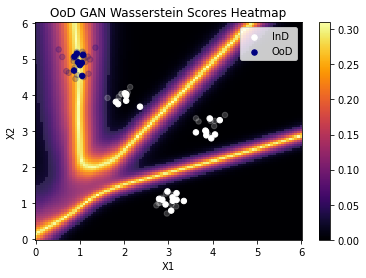

In [174]:
# plt.pcolormesh(xi, yi, mask.reshape((m, m)).T, shading='auto',cmap='gray', alpha=0.1)
plt.pcolormesh(xi, yi, si_gan.reshape((m, m)).T, shading='auto',cmap='inferno', alpha=1)
plt.colorbar()
plt.pcolormesh(xi, yi, mask.reshape((m, m)).T, shading='auto',cmap='gray', alpha=0.1)
# InD and OoD
ind_idx = np.random.choice(len(IND_X), n_ind, replace=False)
ood_idx = np.random.choice(len(OOD_X), n_ind, replace=False)
plt.scatter(IND_X[:,0][ind_idx], IND_X[:,1][ind_idx], c='white', label ="InD", sizes=[30]*len(IND_X), alpha=1)
plt.scatter(OOD_BATCH[:,0], OOD_BATCH[:,1], c='navy', label="OoD", sizes=[30]*len(OOD_X), alpha=1)
plt.scatter(IND_X_TEST[:,0][ind_idx], IND_X_TEST[:,1][ind_idx], c='white', sizes=[30]*len(IND_X), alpha=0.2)
plt.scatter(OOD_X[:,0][ood_idx], OOD_X[:,1][ood_idx], c='navy', sizes=[30]*len(OOD_X), alpha=0.2)
plt.title(f"OoD GAN Wasserstein Scores Heatmap")
plt.xlabel("X1")
plt.ylabel("X2")
plt.legend()
plt.savefig(f"simulation_log/plot/example.jpg", dpi=1000)

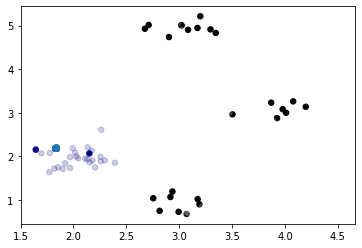

In [126]:
seed = torch.rand((bsz_tri, 2), device=DEVICE)
Gz = G_GAN(seed).detach().numpy()
plt.scatter(IND_X[:,0][ind_idx], IND_X[:,1][ind_idx], c='black', label ="InD", sizes=[30]*len(IND_X), alpha=1)
plt.scatter(OOD_BATCH[:,0], OOD_BATCH[:,1], c='navy', label="OoD", sizes=[30]*len(OOD_X), alpha=1)
plt.scatter(IND_X_TEST[:,0][ind_idx], IND_X_TEST[:,1][ind_idx], c='white', sizes=[30]*len(IND_X), alpha=0.2)
plt.scatter(OOD_X[:,0][ood_idx], OOD_X[:,1][ood_idx], c='navy', sizes=[30]*len(OOD_X), alpha=0.2)
plt.scatter(Gz[:,0], Gz[:,1])

### Save

In [556]:
torch.save(D, "simulation_log/example/D.pt")
torch.save(D_WOOD, "simulation_log/example/D_WOOD.pt")
torch.save(D_GAN, "simulation_log/example/D_GAN.pt")
torch.save(G_GAN, "simulation_log/example/G_GAN.pt")
torch.save(OOD_BATCH,"simulation_log/example/OOD_BATCH.pt")
torch.save(OOD_X,"simulation_log/example/OOD_X.pt")
torch.save(OOD_X_TEST,"simulation_log/example/OOD_X_TEST.pt")
torch.save(IND_X,"simulation_log/example/IND_X.pt")
torch.save(IND_X_TEST,"simulation_log/example/IND_X_TEST.pt")
torch.save(IND_Y,"simulation_log/example/IND_Y.pt")
torch.save(IND_Y_TEST,"simulation_log/example/IND_Y_TEST.pt")
torch.save(SAMPLERS, 'simulation_log/example/samplers.pt')
torch.save((X_TRAIN, Y_TRAIN, X_TEST, Y_TEST), 'simulation_log/example/raw_data.pt')